# Python fundamentals

<div class="objectives">
  
### Objectives

- Recap why pandas has been the go to package for most of python's history.
- Explore pitfalls of pandas and python in general.
- What does parallel mean?

</div>

### What is Parallel - Why is python slow (sometimes)

A **process** is a collection of resources including program files and memory, that operates as an independent entity. Since each process has a seperate memory space, it can operate independently from other processes. It cannot easily access shared data in other processes.

A **thread** is the unit of execution within a process. A process can have anywhere from just one thread to many threads. Threads are considered lightweight because they use far less resources than processes. Threads also share the same memory space so are not independent.

Back to python, the multiprocessing library was designed to break down the **Global Interpreter Lock (GIL**) that limits one thread to control the Python interpreter.

![Image](../fig/process_v_thread.png)

In Python, the things that are occurring simultaneously are called by different names (thread, task, process). While they all fall under the definition of concurrency (multiple things happening anaologous to different trains of thought), only multiprocessing actually runs these trains of thought at literally the same time. We will only cover multiprocessing here which assists in CPU bound operations - but keep in mind other methods exist (multi threading, message passing interface..), whose implementation tends to be more low level.


### Pandas Dataframes - Recap The Staple of Python data manipulation

Pandas has been the standard in Python for many years

1. Has an extensive set of Features.
2. Represent commond datastructures and operatings.
3. Efficiency (when using the optimised c code under the hood).
4. Wide integration with other open source libraries.

Lets recap how its used in common workflows which generally consis of reading and inspecting data, data manipulation and applying functions from other packages and finally plotting main results.

In [1]:
# Import libraries and datasets
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import dask

ts_data = dask.datasets.timeseries()
df = sns.load_dataset('diamonds')
df.head() #inspect DataFrame


/Users/kris/miniconda3/envs/parallel/lib/python3.9/site-packages/dask_expr/_collection.py:5968: UserWarning: dask_expr does not support the DataFrameIOFunction protocol for column projection. To enable column projection, please ensure that the signature of `func` includes a `columns=` keyword argument instead.
  warnings.warn(


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### DataFrame Functions
Functions are available that are attached to the DataFrame class
Common methods are: 

- **filter**: Subset the dataframe rows or columns according to the specified index labels. 
- **assign**: assign / mutate new columns in dataframe
- **query**: query the columns of a DataFrame with a boolean expression
- **sort_values** : arrange rows of DataFrame
- **apply** : Apply a function along an axis of the DataFrame

/var/folders/j2/6znnc26n7r9gk1qjgh7wy6bh0000gn/T/ipykernel_3755/2303346034.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('cut').price.agg('std')
/var/folders/j2/6znnc26n7r9gk1qjgh7wy6bh0000gn/T/ipykernel_3755/2303346034.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('cut').mean(numeric_only=True)
/var/folders/j2/6znnc26n7r9gk1qjgh7wy6bh0000gn/T/ipykernel_3755/2303346034.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

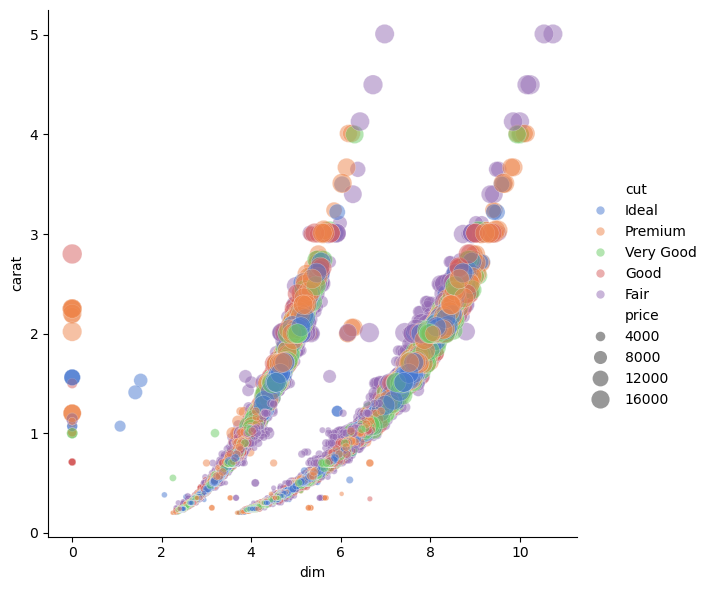

In [2]:
# A whole bunch of stuff - recap on pandas

# DataFrame attributes can be accessed

df.index # name of index, in this case a range
df.columns # variables carat to z
df.values # values as a numpy.ndarray
df.dtypes # data types of variables
df.shape # rows to column structure
df.ndim # number of dimensions

# functions are attached to pd.Series can be engaged
df.cut    # referenced column on its own
df.cut.value_counts()   
df.cut.unique()
df.carat.mean()

# filter variables
df.filter(['cut']) # returns pandas.DataFrame
df['cut'] # as opposed to this which returns pandas.Series or df.cut
df.filter(["carat","cut"]) # filter more than one variables 
df.filter(regex=  "^c") # with regex - a whole other topic...

# query observations
# The quotes in query need to be single-outside, double-inside 
df.query('color == "E"') # filter observations by criteria
df.query('cut == "Ideal" or cut == "Premium"') # filter observations with logical expression
df.query('cut == "Ideal" | cut == "Premium"')  # same thing
df.query("cut.str.match('^G')") # query doesn't have regex parameter but can be incorporated via str attribute
df.query("clarity.str.contains('^\w+1')")
df.query('price > 500') # querying numeric

# other ways to filter variables or observations by string exist
subset = [col for col in df.columns.str.contains('c')] # list comprehension returning list of booleans
df.filter(df.columns[subset]) # which are tweaked to filter command
df[df.cut.str.startswith('Good')] # subsetting observations 

# most DataFrame functions return a DataFrame so one can combine different DataFrame operations
df.query('price < 500').head() 

# chaining manipulations into larger readable structure
(df
 .filter(['carat', 'color'])
 .query('color == "E"')
 .head(3))

# or using functions applied after a chain
(df
    .query('price < 4000')
    .price.std())

# While we've only so far looked at functions attached to pd.Dataframe,
# one can use external functions provided what it expects is catered for.

np.linalg.norm(df.filter(['x','y','z']).values) # norm expects an array


# arrange data by values
df.sort_values(by = ['carat','price'],ascending = False)

# groupby: splits DataFrame into multiple compartments and returns a group-by object
# which aggregations can be applied on each group
df.groupby('cut').price.agg('std')
df.groupby('cut').mean(numeric_only=True)

# Using assign to create / mutate a variable

df.assign(size = 1) #fills same value
df = df.assign(size = np.sqrt(df.x ** 2 + df.y ** 2 + df.z ** 2)) #element wise vector addition

# apply : apply a function to a DataFrame over columns (axis = 1) or rows (axis = 0) 
df.assign(norm = df.filter(['x','y','z']).apply(np.linalg.norm,axis = 1)) # element / rowwise norm equivalent

df.assign(demeaned = lambda df : df.price - df.price.mean()) 

#if aggregation is based on grouping
df_cut = df.groupby('cut')
df.assign(demeaned = df.price - df_cut.price.transform('mean')) #transform

# map : Map values of Series according to an input mapping or function.
# very similar to apply but acts on pd.Series rather than pd.DataFrame

df.price.map(lambda r : r + 1) #returns a pd.Series

# applymap: Apply a function to a DataDrame element-wise
df.filter(['x','y','z']).applymap(lambda x : x **2) 

# Reshaping data with melt
# Melt converts data to long format. 
# pivot is the column equivalent to expand data wider
''' some melt arguments are :
id_vars ; Column(s) to use as identifier variables
value_vars ; Column(s) to unpivot. If not specified, uses all columns that are not set as id_vars.
var_name ; Name to use for the ‘variable’ column
value_name ; Name to use for the ‘value’ column
'''

df_longer = (df.filter(['cut','carat','clarity','x','y','z','price'])
    .melt(id_vars=['cut','price','clarity','carat'], 
    value_vars = ['x','y','z'],
    value_name = "dim"
     )
)

# Longer format usually good for plotting.

sns.relplot(x="dim", y="carat", hue="cut", size="price",
            sizes=(10, 200), alpha=.5, palette="muted",
            height=6, data=df_longer.query('dim < 12'));


<div class="challenge">

### Challenge 

Make a plot of the carat vs price, group the colors by the cut and the symbol size by the color of the diamond. Limit the dataset to just show the "I1" clarity.

<details>
<summary>Solution</summary>

This can be done in a few ways, but Seaborn interfaces with pandas-like dataframes seamlessly to make these simple data-manging tasks easy. 
    
```python   
sns.relplot(x="carat", y="price", hue="cut",size='color',
        sizes=(10, 200), alpha=.5, palette="muted",
        height=6, data=data.query('clarity == "I1"'))
```
</details>
</div>

Some common issues with this typical workflow are:

1. Data may not fit easily into one dataframe 

2. Each data manipulation (and reassignment to a variable) triggers computation.

3. Pandas syntax sometimes difficult to understand and holds too many options to remember.

4. Python GIL prevent threads from running at the same time (for now)


### Aside - Generators may be helpful for functions you define yourself

A Generator in Python is a function that returns an iterator (rather than an actual value/ set of values) using the Yield keyword. Think of it as defining the process rather than processing.

A few useful links with ideas on how to do this:

- [https://caam37830.github.io/book/index.html](https://caam37830.github.io/book/index.html)
- [https://python-course.eu/](https://python-course.eu/)
- [https://realpython.com/fibonacci-sequence-python/](https://realpython.com/fibonacci-sequence-python/)

In [4]:
def FibonacciGenerator(n):
    """ 
    note: n is limit of fibonacci value rather than count
    """
    a = 0
    b = 1
    while a < n:
        yield a
        a, b = b, a + b
        

def is_even(sequence):
    """ reduces a sequence to even numbers
    """
    for n in sequence:
        if n % 2 == 0:
            yield n

In [8]:
# Can consume generators by converting to list
list(is_even([1,2,3,4]))

[2, 4]

In [9]:
list(FibonacciGenerator(500))

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]

In [10]:
# Build up sequences of manipulations in memory with generators 
# and selectively trigger consumption with "list" for efficiency. 
# Conceptually this is using lazy functions which we will talk more about.
list(is_even(FibonacciGenerator(500)))

[0, 2, 8, 34, 144]

<div class="keypoints">

### Key points

- Stay within the pandas, numpy ecosystem as much as possible (its c code under the hood)
- Consider building a series of generators
- The GIL prevents python from utilising multple cores effectively on your machine.

</div>
